<br><br>
<font size = "6">
<b>Recurrent Neural Networks (RNN)</b>
</font><br><br>

<br>
<div class="pull-right">
  Prof. Sooyoung Lee<br>
  <a href="https://iai.cau.ac.kr/" target="_blank">https://iai.cau.ac.kr/</a><br>
  Industrial AI Lab at Chung-Ang University
</div>

Table of Contents
<div id="toc"></div>

# 1. Recurrent Neural Network (RNN)


- RNNs are a family of neural networks for processing sequential data

## 1.1. Feedforward Network and Sequential Data




<br>
<center>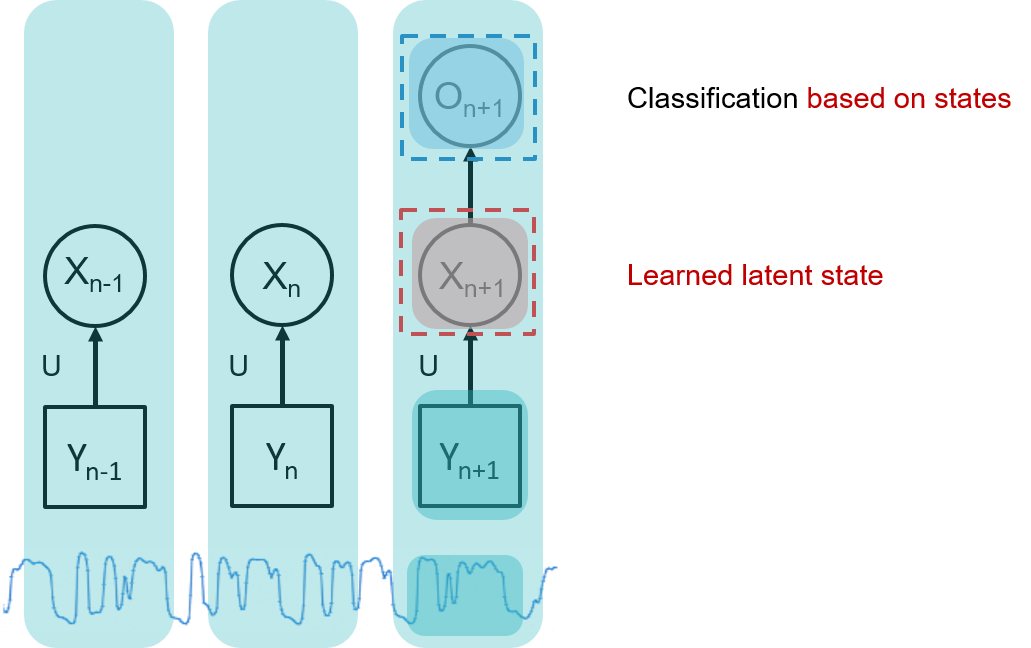</center>
<br>


- Separate parameters for each value of the time index


- Cannot share statistical strength across different time indices



<br>
<center>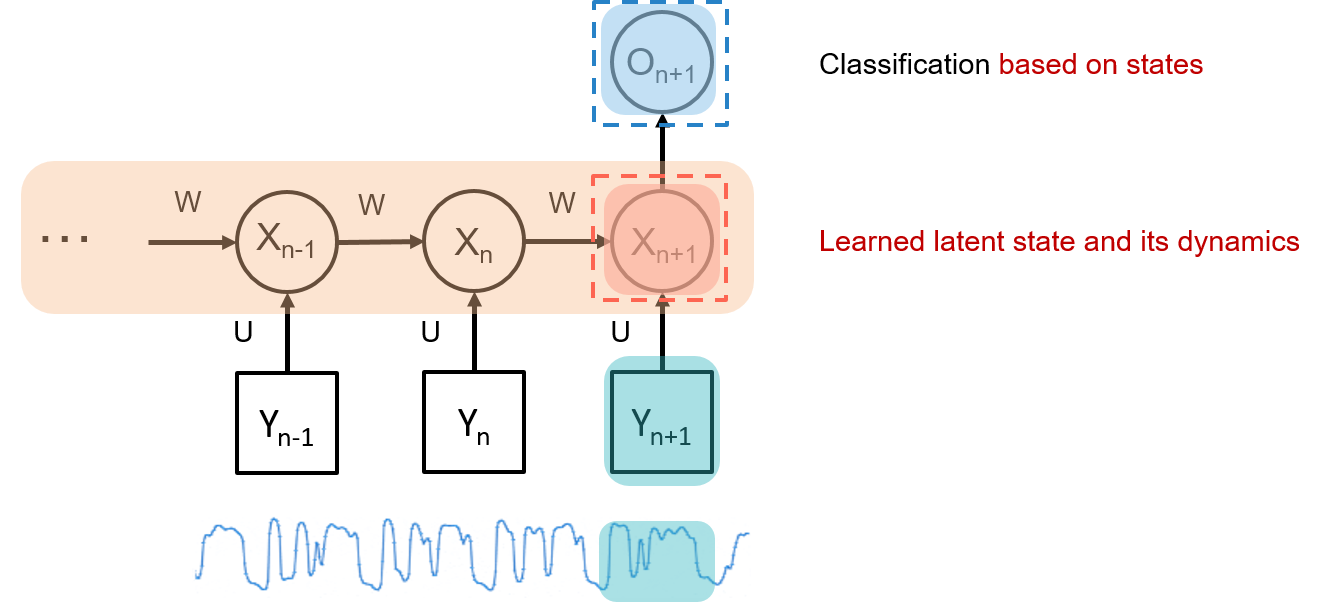</center>
<br>


## 1.2. Representation Shortcut


- Input at each time is a vector
- Each layer has many neurons
- Output layer too may have many neurons
- But will represent everything simple boxes
- Each box actually represents an entire layer with many units




<br>
<center>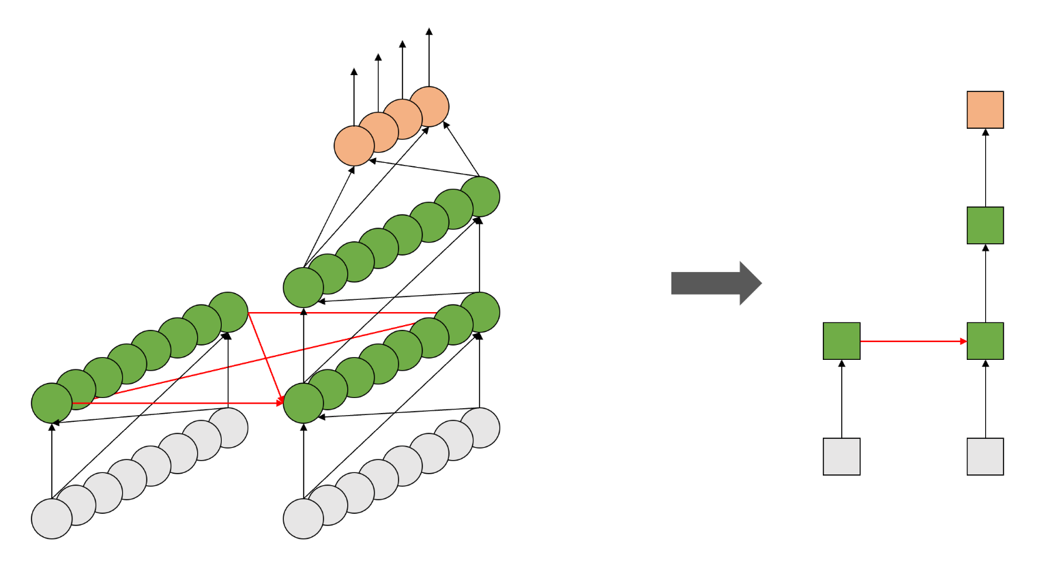</center>
<br>


## 1.3. An Alternate Model for Infinite Response Systems


- The state-space model

<br>

$$
\begin{align*}
h_t &= f(x_t, h_{t-1})\\
y_t &= g(h_t)
\end{align*}
$$

<br>

- This is a recurrent neural network
- State summarizes information about the entire past


- Single Hidden Layer RNN (Simplest State-Space Model)



<br>
<center>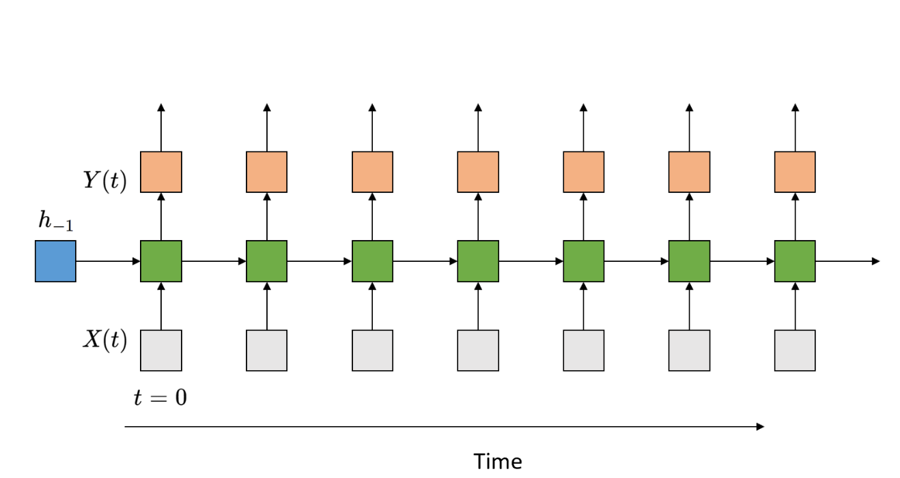</center>
<br>



- Multiple Recurrent Layer RNN



<br>
<center>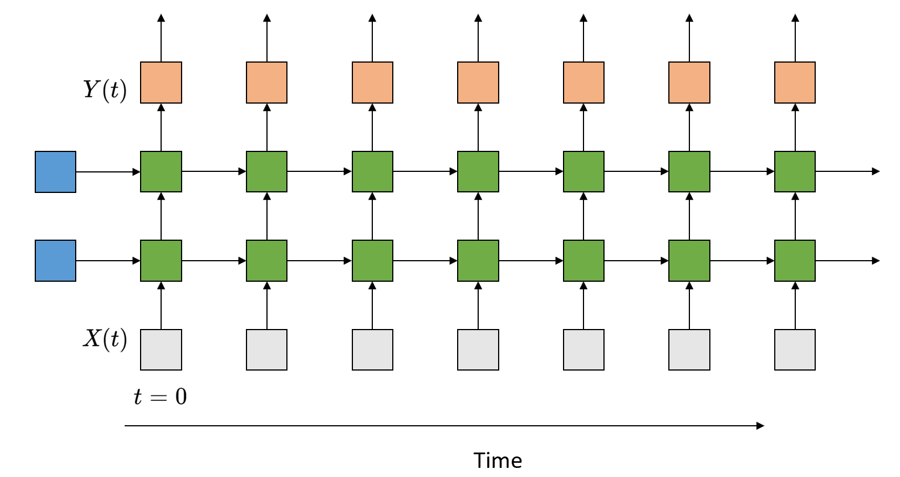</center>
<br>




- Recurrent Neural Network
    - Simplified models often drawn
    - The loops imply recurrence



<br>
<center>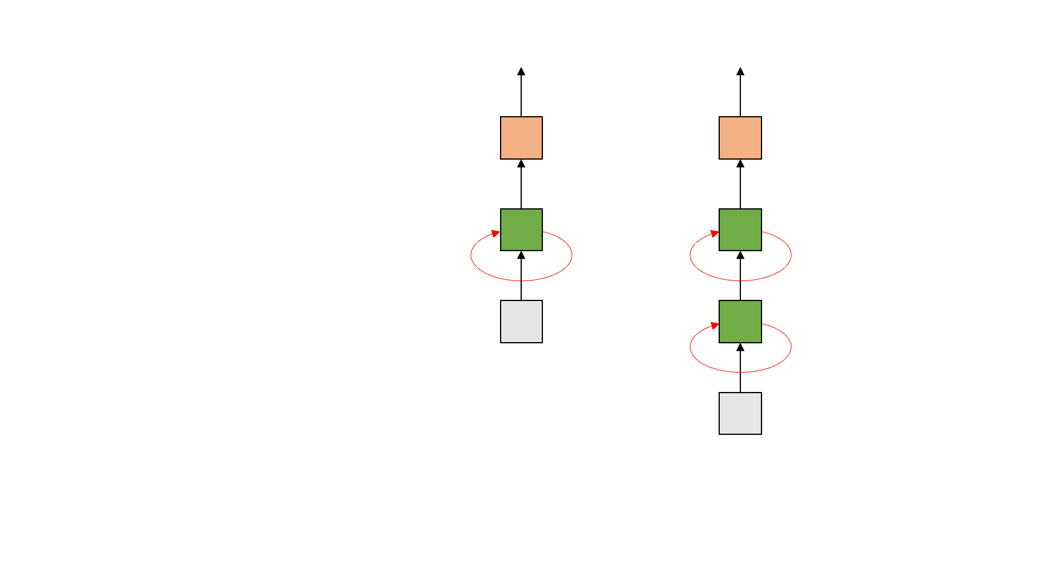</center>
<br>

# 2. LSTM Networks

## 2.1. Long-Term Dependencies

- Gradients propagated over many stages tend to either __vanish__ or __explode__
- Difficulty with long-term dependencies arises from the exponentially smaller weights given to long-term interactions
- Introduce a memory state that runs through only linear operators
- Use gating units to control the updates of the state




<br>
<center>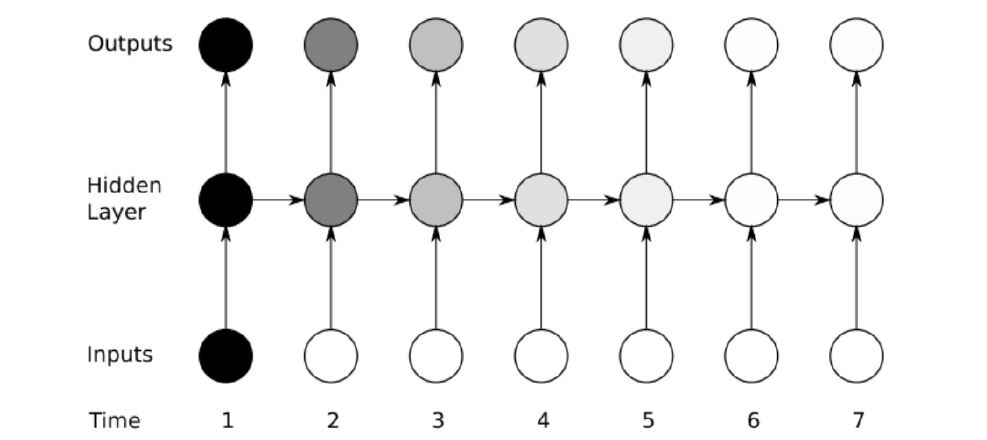</center>
<br>




Example: "I grew up in France… I speak fluent _French_."



<br>
<center>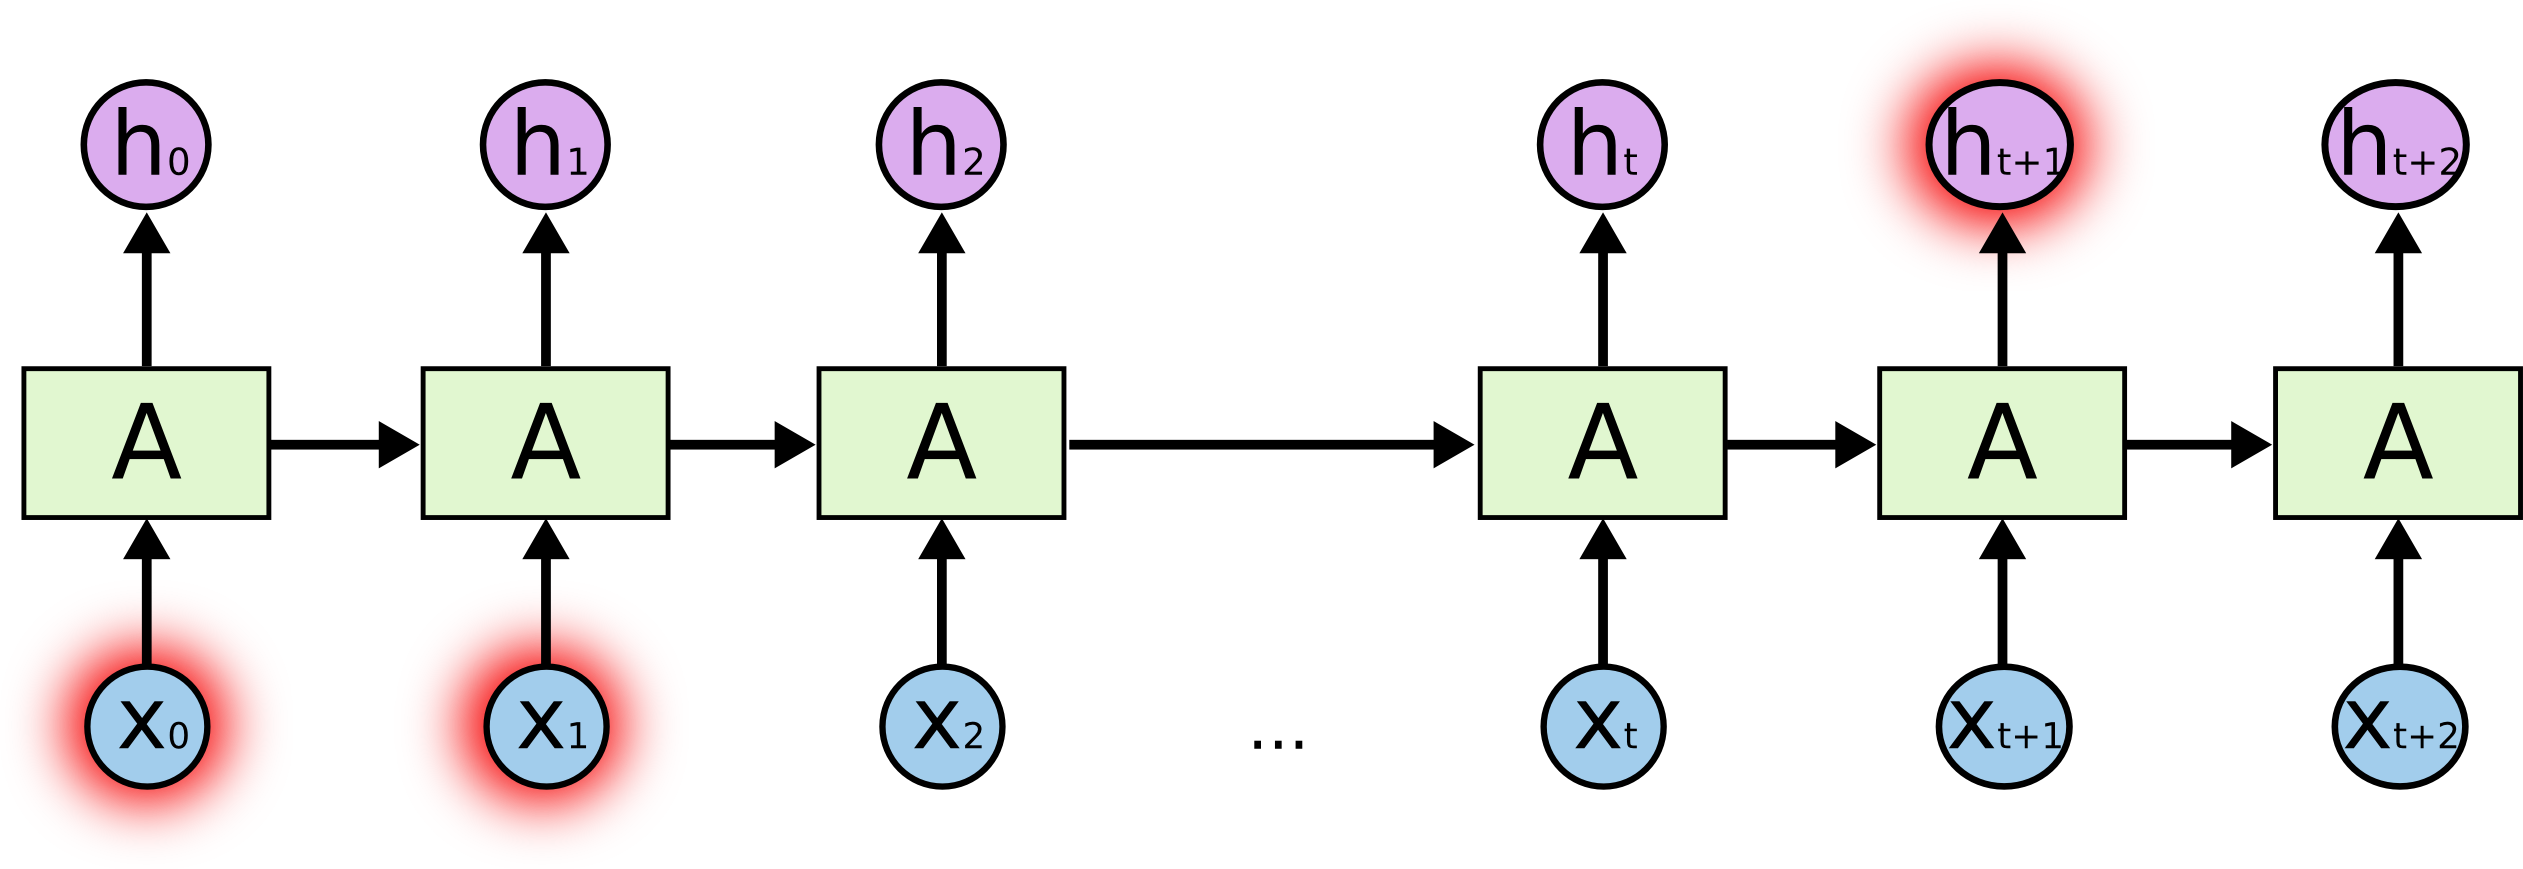</center>
<br>


## 2.2. Long Short-Term Memory (LSTM)

- Consists of a memory cell and a set of gating units
    - Memory cell is the context that carries over
    - Forget gate controls erase operation
    - Input gate controls write operation
    - Output gate controls the read operation




<br>
<center>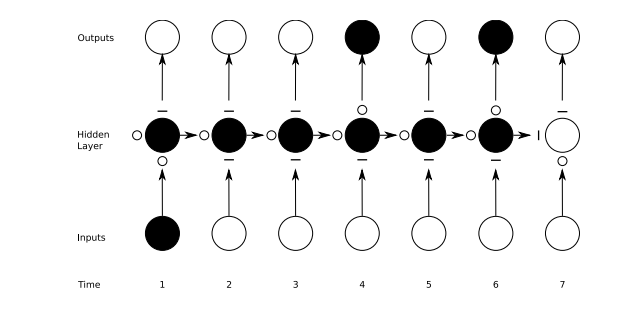</center>

<br>
<center>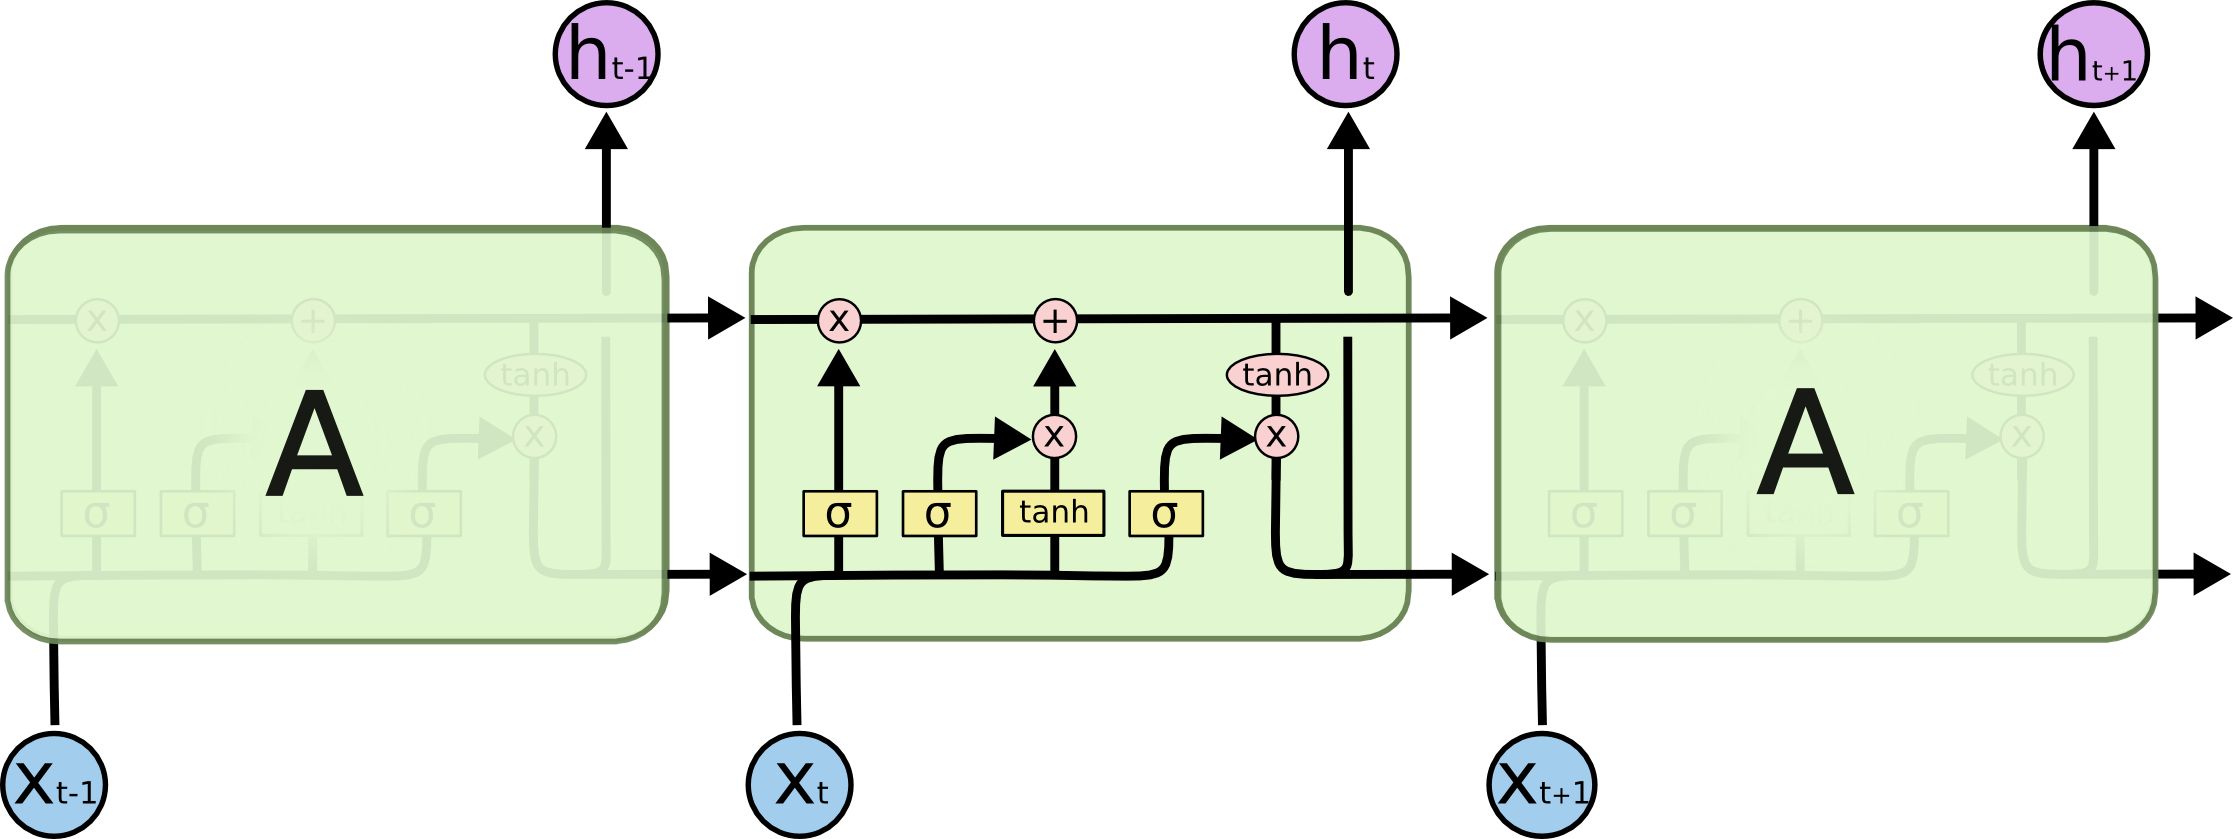</center>
<br>



- Connect LSTM cells in a recurrent manner
- Train parameters in LSTM cells

### 2.2.1. LSTM for Classification



<br><br>
<center>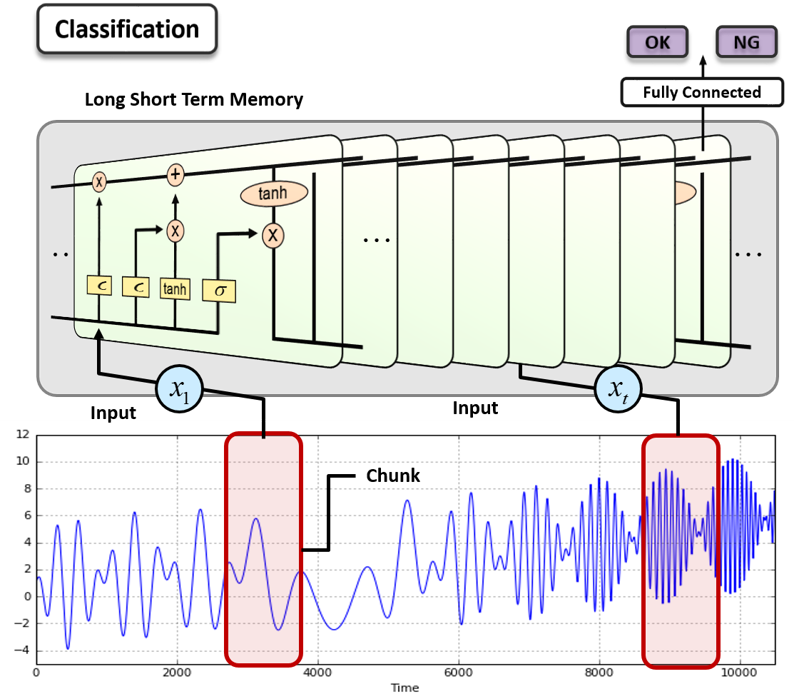</center>


### 2.2.2. LSTM for Prediction



<br><br>
<center>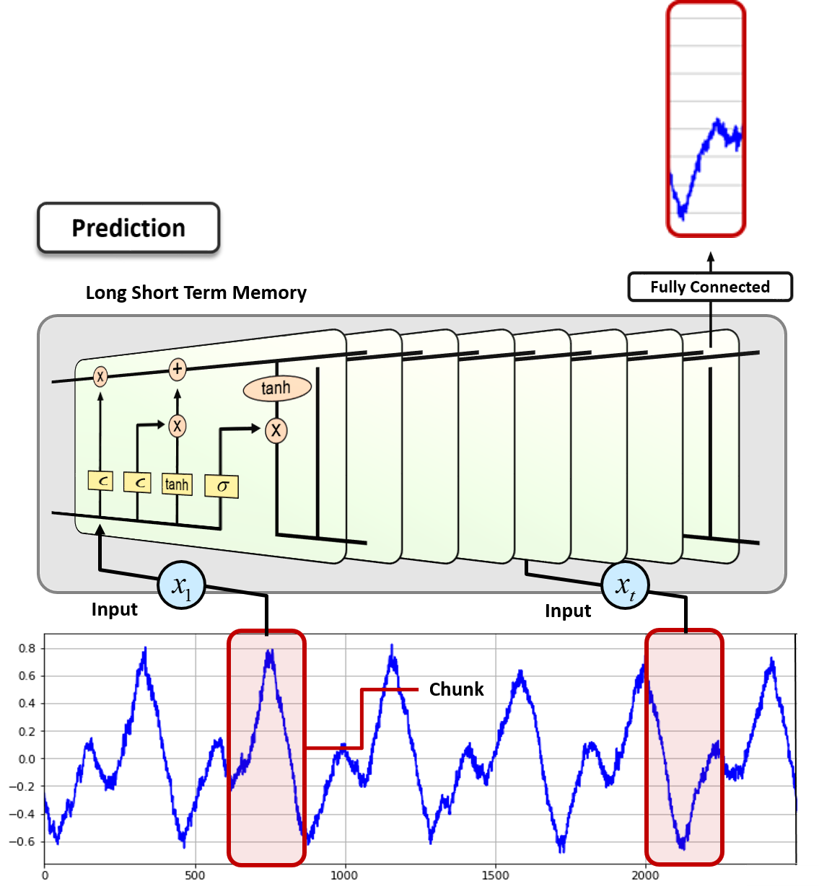</center>

# 3. LSTM with PyTorch: Power Generation Estimation

- In this example, we are going to predict sequence data using LSTM model
- The data, which includes variables such as combustor power, compressor power, compressor pressure, blade tip temperature, blade tip acceleration, blade tip velocity, and relative pressure, is given at every minute.
- We will create a deep learning model that makes use of sequential properties.
- The combustor power for time $t$ will be predicted using the data provided at time $t−1$.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd

In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## 3.1. Load Dataset

In [26]:
df = pd.read_csv('./dataset/power_generation.csv')
df['dt'] = pd.to_datetime(df['dt'])
df = df.set_index('dt') 
df

,Combustor power,Compressor power,Blade tip temperature,Compressor pressure,Blade tip acceleration,Relative pressure,Blade tip velocity
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0
2010-11-26 20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0
2010-11-26 21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0


In order to reduce the computation time, data were resampled in hour units to reduce the computational time (original data is provided in minutes). This will reduce the size of data from 2075259 to 34589 but keep the overall strucure of data as shown in the below

In [27]:
df_resample = df.resample('h').mean() 
df_resample

,Combustor power,Compressor power,Blade tip temperature,Compressor pressure,Blade tip acceleration,Relative pressure,Blade tip velocity
dt,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667
...,...,...,...,...,...,...,...
2010-11-26 17:00:00,1.725900,0.061400,237.069667,7.216667,0.0,0.000000,12.866667
2010-11-26 18:00:00,1.573467,0.053700,237.531833,6.620000,0.0,0.000000,0.000000
2010-11-26 19:00:00,1.659333,0.060033,236.741000,7.056667,0.0,0.066667,0.000000


Change the data type from dataframe to array.

In [28]:
dataset = df_resample.values
print(dataset.shape)

(34589, 7)


## 3.2. Data Visualization

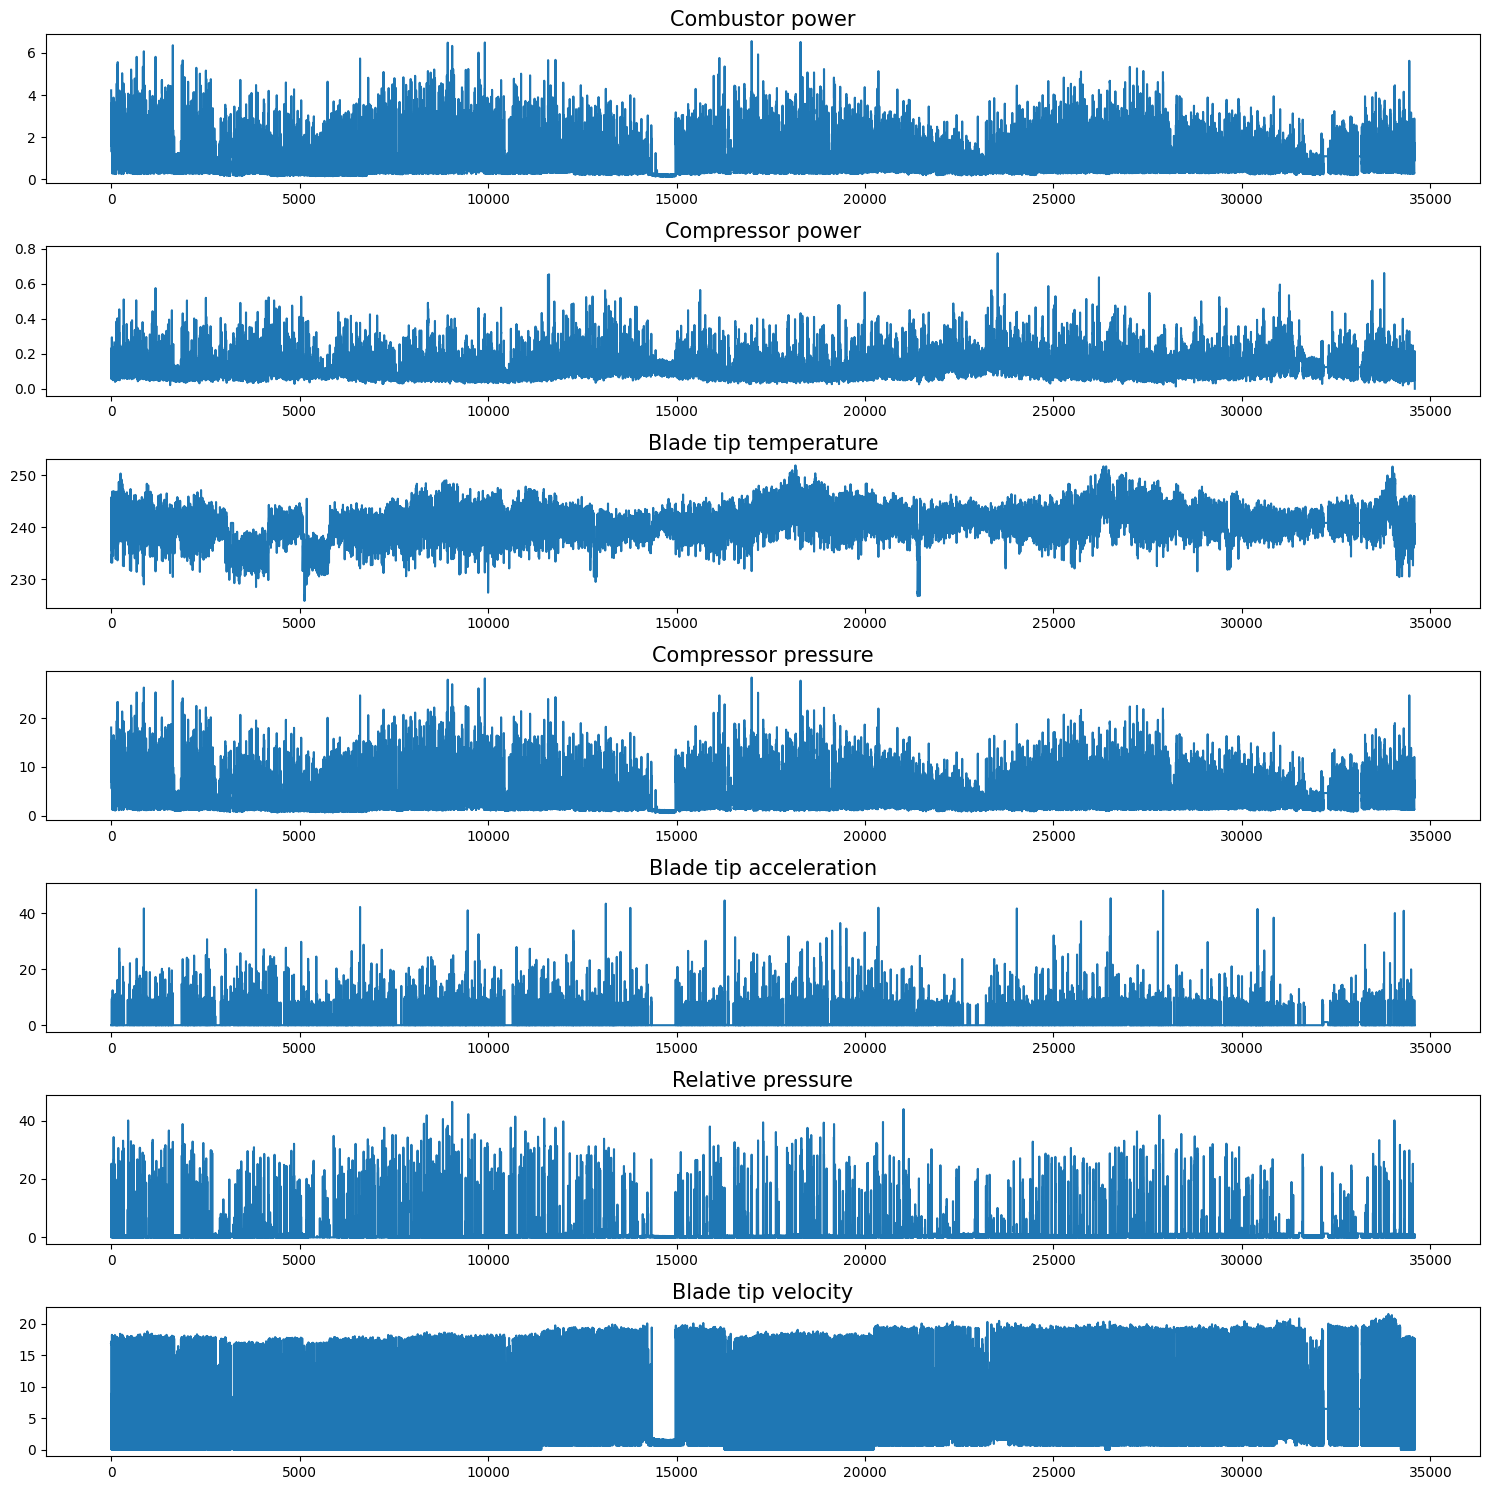

In [29]:
plt.figure(figsize = (15, 15))
for i in range(7):
    plt.subplot(7, 1, i+1)
    plt.plot(dataset[:, i])
    plt.title(df.columns[i], fontsize = 15)
plt.tight_layout()
plt.show()

## 3.3. Preprocessing

- Each variables has different scale. Normalize the dataset using sklearn MinMaxScaler.

In [30]:
from sklearn.preprocessing import MinMaxScaler

In [31]:
scaler = MinMaxScaler(feature_range = (0, 1))
norm_dataset = scaler.fit_transform(dataset)
print('min value:{:.1f}, max value:{:.1f}'.format(np.min(norm_dataset), np.max(norm_dataset)))

print(norm_dataset.shape)

min value:0.0, max value:1.0
(34589, 7)


## 3.4. Split Dataset

![image](https://github.com/user-attachments/assets/9d81cf31-c89e-4793-9360-7c5f85c2dbab)


In [32]:
train_data, target_data = norm_dataset[:-1, :], norm_dataset[1:, 0]

# Set trainset to 3 years and the teestset to the remaining data
n_train_time = 365 * 24 * 3

train_X, train_y = train_data[:n_train_time, :], target_data[:n_train_time]
test_X, test_y = train_data[n_train_time:, :], target_data[n_train_time:]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

train_X = np.transpose(train_X, (0, 2, 1))
test_X = np.transpose(test_X, (0, 2, 1))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

(26280, 7, 1) (26280,) (8308, 7, 1) (8308,)


In [49]:
train_data_tensor = torch.tensor(train_X, dtype=torch.float32)
train_label_tensor = torch.tensor(train_y, dtype=torch.float32)
test_data_tensor = torch.tensor(test_X, dtype=torch.float32)

train_dataset = TensorDataset(train_data_tensor, train_label_tensor)

batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [50]:
print((next(iter(train_dataloader)))[0].shape)

torch.Size([128, 7, 1])


## 3.5. LSTM Model

In [59]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # LSTM forward pass
        out, _ = self.lstm(x, (h0, c0))
        
        # Pass through the fully connected layer
        out = self.fc(out[:, -1, :])
        
        return out

In [60]:
input_size = train_X.shape[2]
hidden_size = 100
output_size = 1

In [61]:
model = LSTMModel(input_size, hidden_size, output_size).to(device)
print(model)

LSTMModel(
  (lstm): LSTM(1, 100, num_layers=2, batch_first=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)


## 3.6. Loss Function and Optimizer

In [62]:
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
loss_function = torch.nn.MSELoss()

## 3.7. Training

In [63]:
model.train()
num_epochs = 30

for epoch in range(num_epochs):
    running_loss = 0.0

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs.squeeze(1), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_dataloader):.4f}')

    running_loss = 0.0

print('Finished Training')


Epoch [1/30], Loss: 0.0142
Epoch [2/30], Loss: 0.0115
Epoch [3/30], Loss: 0.0110
Epoch [4/30], Loss: 0.0108
Epoch [5/30], Loss: 0.0107
Epoch [6/30], Loss: 0.0105
Epoch [7/30], Loss: 0.0104
Epoch [8/30], Loss: 0.0103
Epoch [9/30], Loss: 0.0102
Epoch [10/30], Loss: 0.0100
Epoch [11/30], Loss: 0.0099
Epoch [12/30], Loss: 0.0099
Epoch [13/30], Loss: 0.0099
Epoch [14/30], Loss: 0.0098
Epoch [15/30], Loss: 0.0097
Epoch [16/30], Loss: 0.0097
Epoch [17/30], Loss: 0.0096
Epoch [18/30], Loss: 0.0095
Epoch [19/30], Loss: 0.0096
Epoch [20/30], Loss: 0.0096
Epoch [21/30], Loss: 0.0095
Epoch [22/30], Loss: 0.0094
Epoch [23/30], Loss: 0.0094
Epoch [24/30], Loss: 0.0094
Epoch [25/30], Loss: 0.0094
Epoch [26/30], Loss: 0.0095
Epoch [27/30], Loss: 0.0094
Epoch [28/30], Loss: 0.0094
Epoch [29/30], Loss: 0.0094
Epoch [30/30], Loss: 0.0094
Finished Training


## 3.8. Evaluation

In [64]:
model.eval()
model = model.cpu()
test_data_tensor = test_data_tensor.cpu()

with torch.no_grad():
    test_pred_tensor = model(test_data_tensor)
    test_pred = test_pred_tensor.cpu().numpy().ravel()

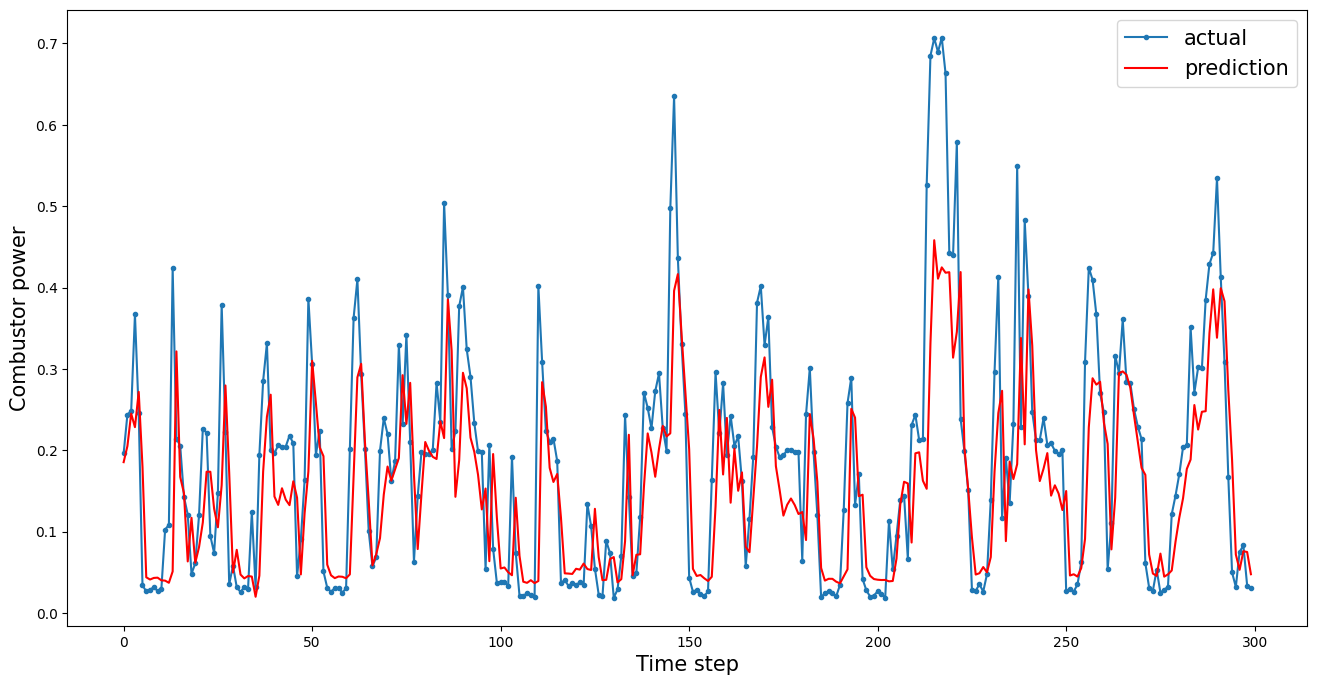

In [67]:
aa = [x for x in range(300)]
plt.figure(figsize = (16,8))
plt.plot(aa, test_y[:300], marker = '.', label = "actual")
plt.plot(aa, test_pred[:300], 'r', label = "prediction")
plt.ylabel('Combustor power', size = 15)
plt.xlabel('Time step', size = 15)
plt.legend(fontsize = 15)
plt.show()

In [ ]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>